In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns


In [51]:
df = pd.read_csv('Data/features_before_augmentation.csv')
X = df.drop(columns='label')
y = df['label']
X.shape, y.value_counts()


((1440, 36),
 calm        192
 happy       192
 sad         192
 angry       192
 fear        192
 disgust     192
 surprise    192
 neutral      96
 Name: label, dtype: int64)

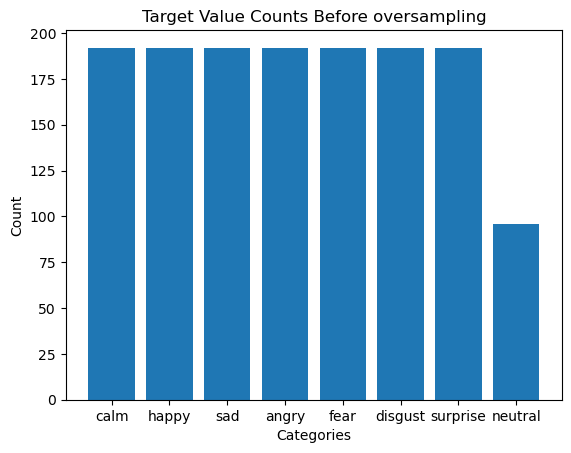

In [56]:
y_value_counts = y.value_counts()


plt.bar(y_value_counts.index, y_value_counts.values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Target Value Counts Before oversampling')
plt.show()

In [53]:

oversampler = RandomOverSampler(sampling_strategy={'neutral': int(y.value_counts().max())}, random_state=42)


X_resampled, y_resampled = oversampler.fit_resample(X, y)


df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='label')], axis=1)

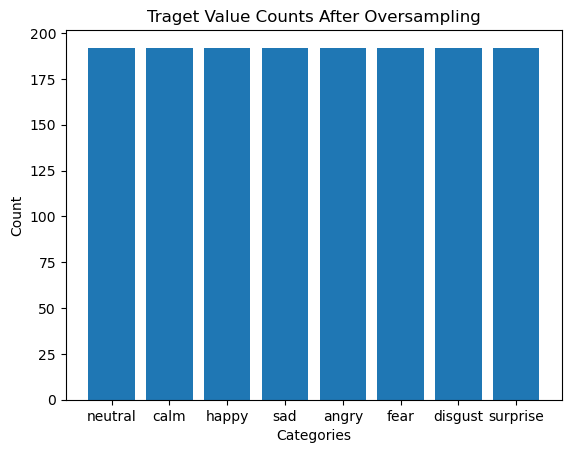

In [57]:
y_resampled_value_counts = y_resampled.value_counts()


plt.bar(y_resampled_value_counts.index, y_resampled_value_counts.values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Traget Value Counts After Oversampling')
plt.show()

In [49]:
X = df_resampled.drop(columns='label')
y = df_resampled['label']
X.shape, y.value_counts()

((1536, 36),
 neutral     192
 calm        192
 happy       192
 sad         192
 angry       192
 fear        192
 disgust     192
 surprise    192
 Name: label, dtype: int64)

In [28]:

le = LabelEncoder()
y_encoded = le.fit_transform(y)


y_one_hot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(np.unique(y_encoded)))
y_one_hot

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [29]:

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train_encoded.shape, y_test_encoded.shape

((1228, 36), (308, 36), (1228, 8), (308, 8))

In [30]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  


custom_optimizer = Adam(learning_rate=0.0001) 
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train_scaled, y_train_encoded, epochs=100, batch_size=30, validation_split=0.2, verbose=1)

Epoch 1/100
33/33 [==============================] - 1s 7ms/step - loss: 2.1038 - accuracy: 0.1141 - val_loss: 2.0759 - val_accuracy: 0.1585
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 2.0244 - accuracy: 0.1925 - val_loss: 2.0293 - val_accuracy: 0.1992
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 1.9637 - accuracy: 0.2739 - val_loss: 1.9890 - val_accuracy: 0.2358
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 1.9077 - accuracy: 0.3228 - val_loss: 1.9530 - val_accuracy: 0.2724
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 1.8525 - accuracy: 0.3686 - val_loss: 1.9112 - val_accuracy: 0.2927
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 1.7955 - accuracy: 0.4073 - val_loss: 1.8700 - val_accuracy: 0.3130
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 1.7390 - accuracy: 0.4297 - val_loss: 1.8334 - val_accuracy: 0.3130
Epoch 8/100
3

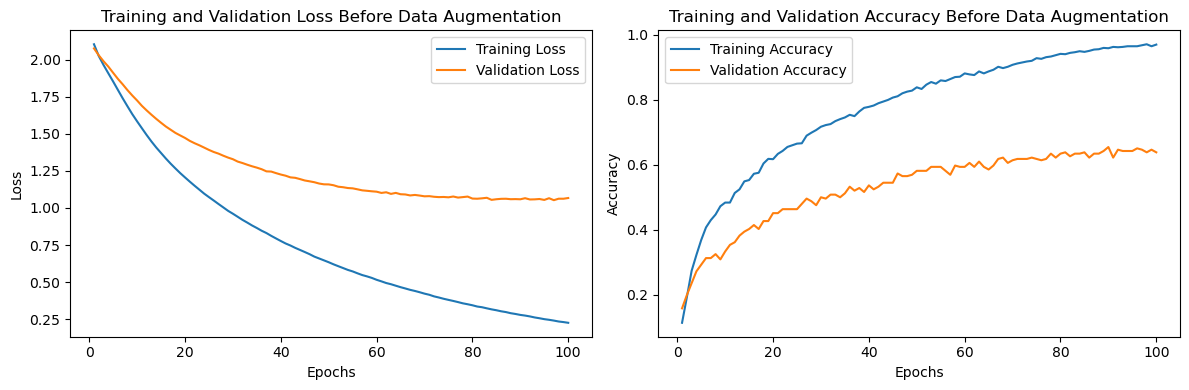

In [46]:

epochs = np.arange(1, len(history.history['loss']) + 1)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(epochs, history.history['loss'], label='Training Loss')
ax[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training and Validation Loss Before Data Augmentation')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy Before Data Augmentation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

10/10 [==============================] - 0s 2ms/step


<IPython.core.display.Javascript object>

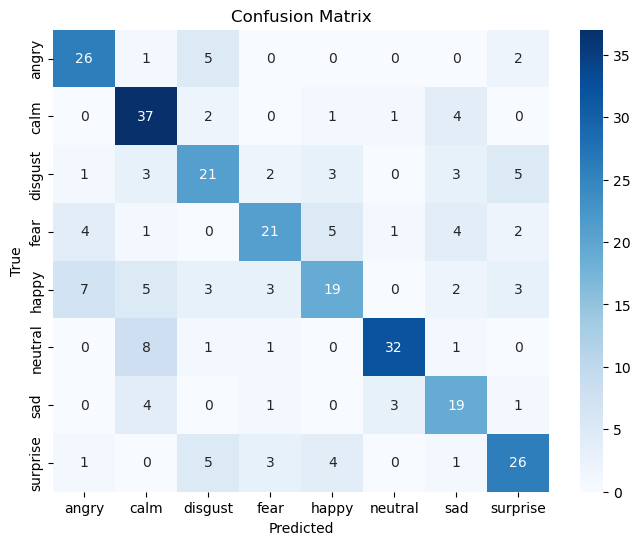

In [41]:

y_pred_encoded = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_encoded, axis=1)
y_true_classes = np.argmax(np.array(y_test_encoded), axis=1)

conf_mat = confusion_matrix(y_true_classes, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [43]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_classes.flatten()
df['Actual Labels'] = y_true_classes.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,0,4
1,4,4
2,3,4
3,6,6
4,1,3
5,6,6
6,3,3
7,1,5
8,6,1
9,7,7


In [44]:
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71        34
           1       0.63      0.82      0.71        45
           2       0.57      0.55      0.56        38
           3       0.68      0.55      0.61        38
           4       0.59      0.45      0.51        42
           5       0.86      0.74      0.80        43
           6       0.56      0.68      0.61        28
           7       0.67      0.65      0.66        40

    accuracy                           0.65       308
   macro avg       0.65      0.65      0.65       308
weighted avg       0.66      0.65      0.65       308

